In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1 | Libraries

In [ ]:
#pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

from sklearn import model_selection
from sklearn import metrics, ensemble, linear_model
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore') 


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Partial Dependence Plots
#from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay


# 2 | Data loading

In [3]:
# import kaggle data
features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
train = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
stores = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
population=pd.read_excel('/kaggle/input/monthly-usa-population-from-2010-to-2014/na-est2019-01.xlsx',skiprows=1)
sample_submission = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')


In [4]:
features.head(2)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True

In [5]:
train_test=pd.concat([train,test])
print(train_test.isnull().sum(),train_test.shape)
train_test.head(2)

Store                0
Dept                 0
Date                 0
Weekly_Sales    115064
IsHoliday            0
dtype: int64 (536634, 5)


Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True

In [6]:
#sum dep
#train1=train.groupby(['Store','Date','IsHoliday']).aggregate({'Weekly_Sales':'sum'}).reset_index()
#train1.head()

In [6]:
# create monthe features
population['Month'] = population['Year and Month'].apply(lambda x: x.strftime('%Y-%m'))
population['Month']= pd.to_datetime(population['Month'])
population=population.drop(columns=['Year and Month'])
population.head()

Resident Population      Month
0          308381809.3 2010-02-01
1          308568855.5 2010-03-01
2          308758105.0 2010-04-01
3          308943167.0 2010-05-01
4          309122946.0 2010-06-01

In [7]:
feature_store = features.merge(stores, how='left', on = "Store")
print(feature_store.isnull().sum(),feature_store.shape)
feature_store.head(2)

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
Type               0
Size               0
dtype: int64 (8190, 14)


Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type  \
0        NaN        NaN        NaN  211.096358         8.106      False    A   
1        NaN        NaN        NaN  211.242170         8.106       True    A   

     Size  
0  151315  
1  151315

In [9]:
feature_store_df = feature_store.merge(train_test, how='right', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Date']).reset_index(drop=True)
print(feature_store_df.isnull().sum())
feature_store_df.head(2)

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI              38162
Unemployment     38162
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales    115064
dtype: int64


Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-05        42.31       2.572        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type  \
0        NaN        NaN        NaN  211.096358         8.106      False    A   
1        NaN        NaN        NaN  211.096358         8.106      False    A   

     Size  Dept  Weekly_Sales  
0  151315     1      24924.50  
1  151315     2      50605.27

In [10]:
# drop null
#feature_store_df_dropnull=feature_store_df.drop(feature_store_df.loc[feature_store_df["CPI"].isnull()].index,axis=0)
#print(feature_store_df_dropnull.isnull().sum())


In [10]:
feature_store_df['CPI'].fillna(feature_store_df['CPI'].mean(),inplace=True)
feature_store_df['Unemployment'].fillna(feature_store_df['Unemployment'].mean(),inplace=True)
print(feature_store_df.isnull().sum())

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales    115064
dtype: int64


In [11]:
feature_store_df_dropnull=feature_store_df.copy()
print(feature_store_df_dropnull.isnull().sum())

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales    115064
dtype: int64


In [12]:
# add population
feature_store_df_dropnull["Date"]=pd.to_datetime(feature_store_df_dropnull["Date"])

feature_store_df_dropnull['Month'] = feature_store_df_dropnull['Date'].apply(lambda x: x.strftime('%Y-%m'))
feature_store_df_dropnull['Month'] = pd.to_datetime(feature_store_df_dropnull['Month'])


In [13]:
# combine with population
df = feature_store_df_dropnull.merge(population, how='left', on = ['Month']).sort_values(by=['Store','Date']).reset_index(drop=True)
print(df.isnull().sum(),df.shape)
df.head(5)

Store                       0
Date                        0
Temperature                 0
Fuel_Price                  0
MarkDown1              271038
MarkDown2              338949
MarkDown3              294308
MarkDown4              299491
MarkDown5              270138
CPI                         0
Unemployment                0
IsHoliday                   0
Type                        0
Size                        0
Dept                        0
Weekly_Sales           115064
Month                       0
Resident Population         0
dtype: int64 (536634, 18)


Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
2      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
3      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
4      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type    Size  \
0        NaN        NaN  211.096358         8.106      False    A  151315   
1        NaN        NaN  211.096358         8.106      False    A  151315   
2        NaN        NaN  211.096358         8.106      False    A  151315   
3        NaN        NaN  211.096358         8.106      False    A  151315   
4        NaN        NaN  211.096358         8.106      False    A  151315   

   Dept  Weekly_Sales      Month  Resident Population  
0     1      24924.50 2010-02-01          308381809.3  
1     2      50605.27 2010-02-01          308381809.3  
2     3      13740.12 2010-02-01          308381809.3  
3     4      39954.04 2010-02-01          308381809.3  
4     5      32229.38 2010-02-01          308381809.3

In [14]:
# fillna 0
for col in df.columns[3:9]:
    df[col] = df[col].fillna(0)
print(df.isnull().sum(),df.shape)

Store                       0
Date                        0
Temperature                 0
Fuel_Price                  0
MarkDown1                   0
MarkDown2                   0
MarkDown3                   0
MarkDown4                   0
MarkDown5                   0
CPI                         0
Unemployment                0
IsHoliday                   0
Type                        0
Size                        0
Dept                        0
Weekly_Sales           115064
Month                       0
Resident Population         0
dtype: int64 (536634, 18)


In [15]:
# map seasonal with month
df["Month"]=df["Month"].astype('string')
def selector(x):
    if '2010-01-01' <= x<='2010-03-01':
        return 'Spring'
    if '2011-01-01' <= x<='2011-03-01':
        return 'Spring'
    if '2012-01-01' <= x<='2012-03-01':
        return 'Spring'
    if '2013-01-01' <= x<='2013-03-01':
        return 'Spring'
    if '2010-04-01' <= x<='2010-06-01':
        return 'Summer'
    if '2011-04-01' <= x<='2011-06-01':
        return 'Summer'
    if '2012-04-01' <= x<='2012-06-01':
        return 'Summer'
    if '2013-04-01' <= x<='2013-06-01':
        return 'Summer'    
    if '2010-07-01' <= x<='2010-09-01':
        return 'Autumn'
    if '2011-07-01' <= x<='2011-09-01':
        return 'Autumn'
    if '2012-07-01' <= x<='2012-09-01':
        return 'Autumn'
    if '2013-07-01' <= x<='2013-09-01':
        return 'Autumn'     
    if '2010-10-01' <= x<='2010-12-01':
        return 'Winter'
    if '2011-10-01' <= x<='2011-12-01':
        return 'Winter'
    if '2012-10-01' <= x<='2012-12-01':
        return 'Winter'
    if '2013-10-01' <= x<='2013-12-01':
        return 'Winter'     
    else:
        return "not_exist"
df["season"] =df["Month"].apply(selector)
df.head(10)

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
1      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
2      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
3      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
4      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
5      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
6      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
7      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
8      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   
9      1 2010-02-05        42.31       2.572        0.0        0.0        0.0   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type    Size  \
0        0.0        0.0  211.096358         8.106      False    A  151315   
1        0.0        0.0  211.096358         8.106      False    A  151315   
2        0.0        0.0  211.096358         8.106      False    A  151315   
3        0.0        0.0  211.096358         8.106      False    A  151315   
4        0.0        0.0  211.096358         8.106      False    A  151315   
5        0.0        0.0  211.096358         8.106      False    A  151315   
6        0.0        0.0  211.096358         8.106      False    A  151315   
7        0.0        0.0  211.096358         8.106      False    A  151315   
8        0.0        0.0  211.096358         8.106      False    A  151315   
9        0.0        0.0  211.096358         8.106      False    A  151315   

   Dept  Weekly_Sales       Month  Resident Population  season  
0     1      24924.50  2010-02-01          308381809.3  Spring  
1     2      50605.27  2010-02-01          308381809.3  Spring  
2     3      13740.12  2010-02-01          308381809.3  Spring  
3     4      39954.04  2010-02-01          308381809.3  Spring  
4     5      32229.38  2010-02-01          308381809.3  Spring  
5     6       5749.03  2010-02-01          308381809.3  Spring  
6     7      21084.08  2010-02-01          308381809.3  Spring  
7     8      40129.01  2010-02-01          308381809.3  Spring  
8     9      16930.99  2010-02-01          308381809.3  Spring  
9    10      30721.50  2010-02-01          308381809.3  Spring

In [17]:
df.season.value_counts()

season
Summer    153000
Spring    135848
Autumn    129220
Winter    118566
Name: count, dtype: int64

In [16]:
df[df['IsHoliday']==True].Date.value_counts()

Date
2011-11-25    3021
2011-12-30    3003
2012-02-10    3001
2012-12-28    2988
2012-11-23    2976
2012-09-07    2966
2013-02-08    2964
2011-09-09    2958
2010-02-12    2956
2010-12-31    2943
2010-11-26    2938
2011-02-11    2938
2010-09-10    2937
Name: count, dtype: int64

In [17]:
# consecutive holidays
df["Date"]=df["Date"].astype('string')
def holiday(x):
    if '2010-02-12' in x:
        return 3
    if '2011-02-11' in x:
        return 3  
    if '2012-02-10' in x:
        return 3  
    if '2013-02-08' in x:
        return 3
    
    if '2010-09-10' in x:
        return 4
    if '2011-09-09' in x:
        return 4  
    if '2012-09-07' in x:
        return 4  
    
    if '2010-11-26' in x:
        return 4    
    if '2011-11-25' in x:
        return 4  
    if '2012-11-23' in x:
        return 4      
    
    if '2010-12-31' in x:
        return 10    
    if '2011-12-30' in x:
        return 10  
    if '2012-12-28' in x:
        return 10      
    
    
    else:
        return 0
df["consecutive_holidays"] =df["Date"].apply(holiday)
df.head(10)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        0.0        0.0   
1      1  2010-02-05        42.31       2.572        0.0        0.0   
2      1  2010-02-05        42.31       2.572        0.0        0.0   
3      1  2010-02-05        42.31       2.572        0.0        0.0   
4      1  2010-02-05        42.31       2.572        0.0        0.0   
5      1  2010-02-05        42.31       2.572        0.0        0.0   
6      1  2010-02-05        42.31       2.572        0.0        0.0   
7      1  2010-02-05        42.31       2.572        0.0        0.0   
8      1  2010-02-05        42.31       2.572        0.0        0.0   
9      1  2010-02-05        42.31       2.572        0.0        0.0   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type  \
0        0.0        0.0        0.0  211.096358         8.106      False    A   
1        0.0        0.0        0.0  211.096358         8.106      False    A   
2        0.0        0.0        0.0  211.096358         8.106      False    A   
3        0.0        0.0        0.0  211.096358         8.106      False    A   
4        0.0        0.0        0.0  211.096358         8.106      False    A   
5        0.0        0.0        0.0  211.096358         8.106      False    A   
6        0.0        0.0        0.0  211.096358         8.106      False    A   
7        0.0        0.0        0.0  211.096358         8.106      False    A   
8        0.0        0.0        0.0  211.096358         8.106      False    A   
9        0.0        0.0        0.0  211.096358         8.106      False    A   

     Size  Dept  Weekly_Sales       Month  Resident Population  season  \
0  151315     1      24924.50  2010-02-01          308381809.3  Spring   
1  151315     2      50605.27  2010-02-01          308381809.3  Spring   
2  151315     3      13740.12  2010-02-01          308381809.3  Spring   
3  151315     4      39954.04  2010-02-01          308381809.3  Spring   
4  151315     5      32229.38  2010-02-01          308381809.3  Spring   
5  151315     6       5749.03  2010-02-01          308381809.3  Spring   
6  151315     7      21084.08  2010-02-01          308381809.3  Spring   
7  151315     8      40129.01  2010-02-01          308381809.3  Spring   
8  151315     9      16930.99  2010-02-01          308381809.3  Spring   
9  151315    10      30721.50  2010-02-01          308381809.3  Spring   

   consecutive_holidays  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0  
9                     0

In [20]:
df[(df['IsHoliday']==True)&(df['consecutive_holidays']==0)]

Empty DataFrame
Columns: [Store, Date, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, IsHoliday, Type, Size, Dept, Weekly_Sales, Month, Resident Population, season, consecutive_holidays]
Index: []

In [21]:
#df.to_excel("walmart sales forecast.xlsx",index=False)

In [22]:
#df.to_csv("walmart sales forecast.csv",index=False)

# Feature engineer

In [18]:
# sum promotion with one features
df['MarkdownsSum'] = df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5'] 

In [19]:
df.isnull().sum()

Store                        0
Date                         0
Temperature                  0
Fuel_Price                   0
MarkDown1                    0
MarkDown2                    0
MarkDown3                    0
MarkDown4                    0
MarkDown5                    0
CPI                          0
Unemployment                 0
IsHoliday                    0
Type                         0
Size                         0
Dept                         0
Weekly_Sales            115064
Month                        0
Resident Population          0
season                       0
consecutive_holidays         0
MarkdownsSum                 0
dtype: int64

In [20]:
# label with catgory features
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x == True else 0)
df['Shop_Type'] = df['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))
#df['season'] = df['season'].apply(lambda x: 1 if x == 'Spring' else (2 if x == 'Summer' else (3 if x == 'Autumn' else (4 if x == 'Winter' else 5))))


In [22]:
# one hot encoder with season
x=df[['season']]
x.head(2)

season
0  Spring
1  Spring

In [23]:
enc=OneHotEncoder(categories='auto').fit(x)
result=enc.transform(x).toarray()
result

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [24]:
newdata=pd.concat([df,pd.DataFrame(result)],axis=1)
newdata.head(2)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        0.0        0.0   
1      1  2010-02-05        42.31       2.572        0.0        0.0   

   MarkDown3  MarkDown4  MarkDown5         CPI  ...       Month  \
0        0.0        0.0        0.0  211.096358  ...  2010-02-01   
1        0.0        0.0        0.0  211.096358  ...  2010-02-01   

   Resident Population  season  consecutive_holidays  MarkdownsSum  Shop_Type  \
0          308381809.3  Spring                     0           0.0          1   
1          308381809.3  Spring                     0           0.0          1   

     0    1    2    3  
0  0.0  1.0  0.0  0.0  
1  0.0  1.0  0.0  0.0  

[2 rows x 26 columns]

In [25]:
newdata.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Type','Month','season'],axis=1,inplace=True)
newdata.head(2)

Store        Date  Temperature  Fuel_Price         CPI  Unemployment  \
0      1  2010-02-05        42.31       2.572  211.096358         8.106   
1      1  2010-02-05        42.31       2.572  211.096358         8.106   

   IsHoliday    Size  Dept  Weekly_Sales  Resident Population  \
0          0  151315     1      24924.50          308381809.3   
1          0  151315     2      50605.27          308381809.3   

   consecutive_holidays  MarkdownsSum  Shop_Type    0    1    2    3  
0                     0           0.0          1  0.0  1.0  0.0  0.0  
1                     0           0.0          1  0.0  1.0  0.0  0.0

In [26]:
newdata.columns=['Store', 'Date', 'Temperature', 'Fuel_Price',  'CPI', 'Unemployment',
       'IsHoliday', 'Size', 'Dept', 'Weekly_Sales', 
       'Resident_Population', 'consecutive_holidays',
      'MarkdownsSum','Shop_Type','season_Autumn','season_Spring','season_Summer','season_Winter']
newdata.sort_values(by=['Store','Dept','Date'],ascending=True,inplace=True)
newdata.head(2)

Store        Date  Temperature  Fuel_Price         CPI  Unemployment  \
0       1  2010-02-05        42.31       2.572  211.096358         8.106   
73      1  2010-02-12        38.51       2.548  211.242170         8.106   

    IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
0           0  151315     1      24924.50          308381809.3   
73          1  151315     1      46039.49          308381809.3   

    consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
0                      0           0.0          1            0.0   
73                     3           0.0          1            0.0   

    season_Spring  season_Summer  season_Winter  
0             1.0            0.0            0.0  
73            1.0            0.0            0.0

In [27]:
# rolling with 4 weeks average
newdata_roll=newdata.copy()
newdata_roll["Temperature"] = newdata_roll["Temperature"].rolling(4).mean()
newdata_roll["Fuel_Price"] = newdata_roll["Fuel_Price"].rolling(4).mean()
newdata_roll["CPI"] = newdata_roll["CPI"].rolling(4).mean()
newdata_roll["Unemployment"] = newdata_roll["Unemployment"].rolling(4).mean()
newdata_roll["Resident_Population"] = newdata_roll["Resident_Population"].rolling(4).mean()
newdata_roll["MarkdownsSum"] = newdata_roll["MarkdownsSum"].rolling(4).mean()
newdata_roll.head(2)


Store        Date  Temperature  Fuel_Price  CPI  Unemployment  IsHoliday  \
0       1  2010-02-05          NaN         NaN  NaN           NaN          0   
73      1  2010-02-12          NaN         NaN  NaN           NaN          1   

      Size  Dept  Weekly_Sales  Resident_Population  consecutive_holidays  \
0   151315     1      24924.50                  NaN                     0   
73  151315     1      46039.49                  NaN                     3   

    MarkdownsSum  Shop_Type  season_Autumn  season_Spring  season_Summer  \
0            NaN          1            0.0            1.0            0.0   
73           NaN          1            0.0            1.0            0.0   

    season_Winter  
0             0.0  
73            0.0

In [28]:
newdata_roll[180:185]


Store        Date  Temperature  Fuel_Price         CPI  Unemployment  \
12887      1  2013-07-19      81.5425     3.46825  172.090481      7.791888   
12957      1  2013-07-26      80.9425     3.49950  172.090481      7.791888   
1          1  2010-02-05      71.5575     3.28700  181.841950      7.870416   
74         1  2010-02-12      60.4050     3.07400  191.629872      7.948944   
146        1  2010-02-19      50.5725     2.81350  201.429538      8.027472   

       IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
12887          0  151315     1           NaN         3.159470e+08   
12957          0  151315     1           NaN         3.159937e+08   
1              0  151315     2      50605.27         3.140907e+08   
74             1  151315     2      44682.74         3.121878e+08   
146            0  151315     2      47928.89         3.102848e+08   

       consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
12887                     0    15136.2225          1            1.0   
12957                     0    12299.0100          1            1.0   
1                         0     6435.2850          1            0.0   
74                        3     3265.1725          1            0.0   
146                       0      572.5475          1            0.0   

       season_Spring  season_Summer  season_Winter  
12887            0.0            0.0            0.0  
12957            0.0            0.0            0.0  
1                1.0            0.0            0.0  
74               1.0            0.0            0.0  
146              1.0            0.0            0.0

In [29]:
newdata_roll_df=newdata_roll[newdata_roll.Date>='2010-02-26'].reset_index(drop=True)
newdata_roll_df.head(2)

Store        Date  Temperature  Fuel_Price         CPI  Unemployment  \
0      1  2010-02-26      41.8450     2.54875  211.236828         8.106   
1      1  2010-03-05      42.8925     2.56200  211.300275         8.106   

   IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
0          0  151315     1      19403.54         3.083818e+08   
1          0  151315     1      21827.90         3.084286e+08   

   consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
0                     0           0.0          1            0.0   
1                     0           0.0          1            0.0   

   season_Spring  season_Summer  season_Winter  
0            1.0            0.0            0.0  
1            1.0            0.0            0.0

In [ ]:
"""
#訓練データ範囲
x1=np.arange(0,330000)
#検証データ範囲
x2=np.arange(330000,440000)
#テストデータ範囲
x3=np.arange(440000,536634)

#平滑化前の時系列データ
#x_all_data=pd.concat([x_train,x_valid,x_test],ignore_index=False)

feature=['Weekly_Sales']
newdata_graph=newdata[feature]

#mat=np.concatenate([x_train_win,x_valid_win,x_test_win],axis=0)

#平滑化後の時系列データ
#x_all_data_win=pd.DataFrame(mat,columns=features)

for column in newdata_graph.columns[:]:
    plt.figure(figsize=(13,8))
    plt.plot(newdata_graph[column].values,color='b')
    #plt.plot(newdata_roll[column].values,color='r')
    ax=plt.gca()
    y_min,y_max=ax.get_ylim()
    
    y1=[y_min]*len(x1)
    y2=[y_max]*len(x1)
    plt.fill_between(x1,y1,y2,facecolor='g',alpha=0.3,label='train')
    
    y1=[y_min]*len(x2)
    y2=[y_max]*len(x2)
    plt.fill_between(x2,y1,y2,facecolor='b',alpha=0.3,label='valid')
    
    y1=[y_min]*len(x3)
    y2=[y_max]*len(x3)
    plt.fill_between(x3,y1,y2,facecolor='r',alpha=0.3,label='test')
    
    plt.legend()
    plt.title(column)
    plt.show()
"""

In [34]:
#features=['Store', 'Date', 'Temperature', 'Fuel_Price',  'CPI', 'Unemployment',
#       'IsHoliday', 'Size', 'Dept', 'Weekly_Sales', 
#       'Resident Population', 'consecutive_holidays',
#       'MarkdownsSum','Type','season']

In [35]:
#newdata=df[features]
#newdata.rename(columns={'Size':'StoreSize','Resident Population':'ResidentPopulation'},inplace=True)
#newdata.head(2)

In [30]:
train_df=newdata_roll_df[newdata_roll_df.Weekly_Sales>=0].reset_index(drop=True)
print(train_df.shape)
train_df.head(2)

(411417, 18)


Store        Date  Temperature  Fuel_Price         CPI  Unemployment  \
0      1  2010-02-26      41.8450     2.54875  211.236828         8.106   
1      1  2010-03-05      42.8925     2.56200  211.300275         8.106   

   IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
0          0  151315     1      19403.54         3.083818e+08   
1          0  151315     1      21827.90         3.084286e+08   

   consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
0                     0           0.0          1            0.0   
1                     0           0.0          1            0.0   

   season_Spring  season_Summer  season_Winter  
0            1.0            0.0            0.0  
1            1.0            0.0            0.0

In [33]:
#train_df.Date.nunique()-143 *0.7=100/4=25
# print(train_df.Date.min(),train_df.Date.max())# 2010-02-05 2012-10-26
# train,2010-02-05~ '2012-01-27' validation 2012- 02-03 ~2012-10-26
#train_df[train_df.Date>'2012-01-01'].Date.unique()

In [31]:
train_data=train_df[train_df.Date<='2012-02-24'].reset_index(drop=True)
train_data['Date'] = train_data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

print(train_data.shape)
train_data.tail(2)

(308118, 18)


Store       Date  Temperature  Fuel_Price         CPI  Unemployment  \
308116     45 2012-02-17      38.6850     3.62975  189.669792         8.424   
308117     45 2012-02-24      39.9175     3.67275  189.792326         8.424   

        IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
308116          0  118221    98        889.98          312896412.5   
308117          0  118221    98        544.34          312932963.0   

        consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
308116                     0    38389.8225          2            0.0   
308117                     0    42482.8325          2            0.0   

        season_Spring  season_Summer  season_Winter  
308116            1.0            0.0            0.0  
308117            1.0            0.0            0.0

In [32]:
var_data=train_df[train_df.Date>='2012-03-02'].reset_index(drop=True)
var_data['Date'] = var_data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
print(var_data.shape)
var_data.head(2)

(103299, 18)


Store       Date  Temperature  Fuel_Price         CPI  Unemployment  \
0      1 2012-03-02      52.8875       3.526  220.543971         7.348   
1      1 2012-03-09      55.5725       3.591  220.742474         7.348   

   IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
0          0  151315     1      20113.03         3.129778e+08   
1          0  151315     1      21140.07         3.130227e+08   

   consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
0                     0     36455.310          1            0.0   
1                     0     31544.895          1            0.0   

   season_Spring  season_Summer  season_Winter  
0            1.0            0.0            0.0  
1            1.0            0.0            0.0

In [33]:
test_data=newdata[newdata.Weekly_Sales.isnull()].reset_index(drop=True)
test_data.drop(['Weekly_Sales'],axis=1,inplace=True)
test_data['Date'] = test_data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
print(test_data.shape)
test_data.head(2)

(115064, 17)


Store       Date  Temperature  Fuel_Price         CPI  Unemployment  \
0      1 2012-11-02        55.32       3.386  223.462779         6.573   
1      1 2012-11-09        61.24       3.314  223.481307         6.573   

   IsHoliday    Size  Dept  Resident_Population  consecutive_holidays  \
0          0  151315     1          314695119.0                     0   
1          0  151315     1          314695119.0                     0   

   MarkdownsSum  Shop_Type  season_Autumn  season_Spring  season_Summer  \
0      18342.28          1            0.0            0.0            0.0   
1      25633.44          1            0.0            0.0            0.0   

   season_Winter  
0            1.0  
1            1.0

In [36]:
#train_data.to_csv("walmart_forecast_train_str.csv",index=False)
#var_data.to_csv("walmart_forecast_var_str.csv",index=False)
#test_data.to_csv("walmart_forecast_test_str.csv",index=False)
#train_df1.to_csv("walmart_forecast_train_str_from20101029.csv",index=False)

# 相関関係

<Axes: >

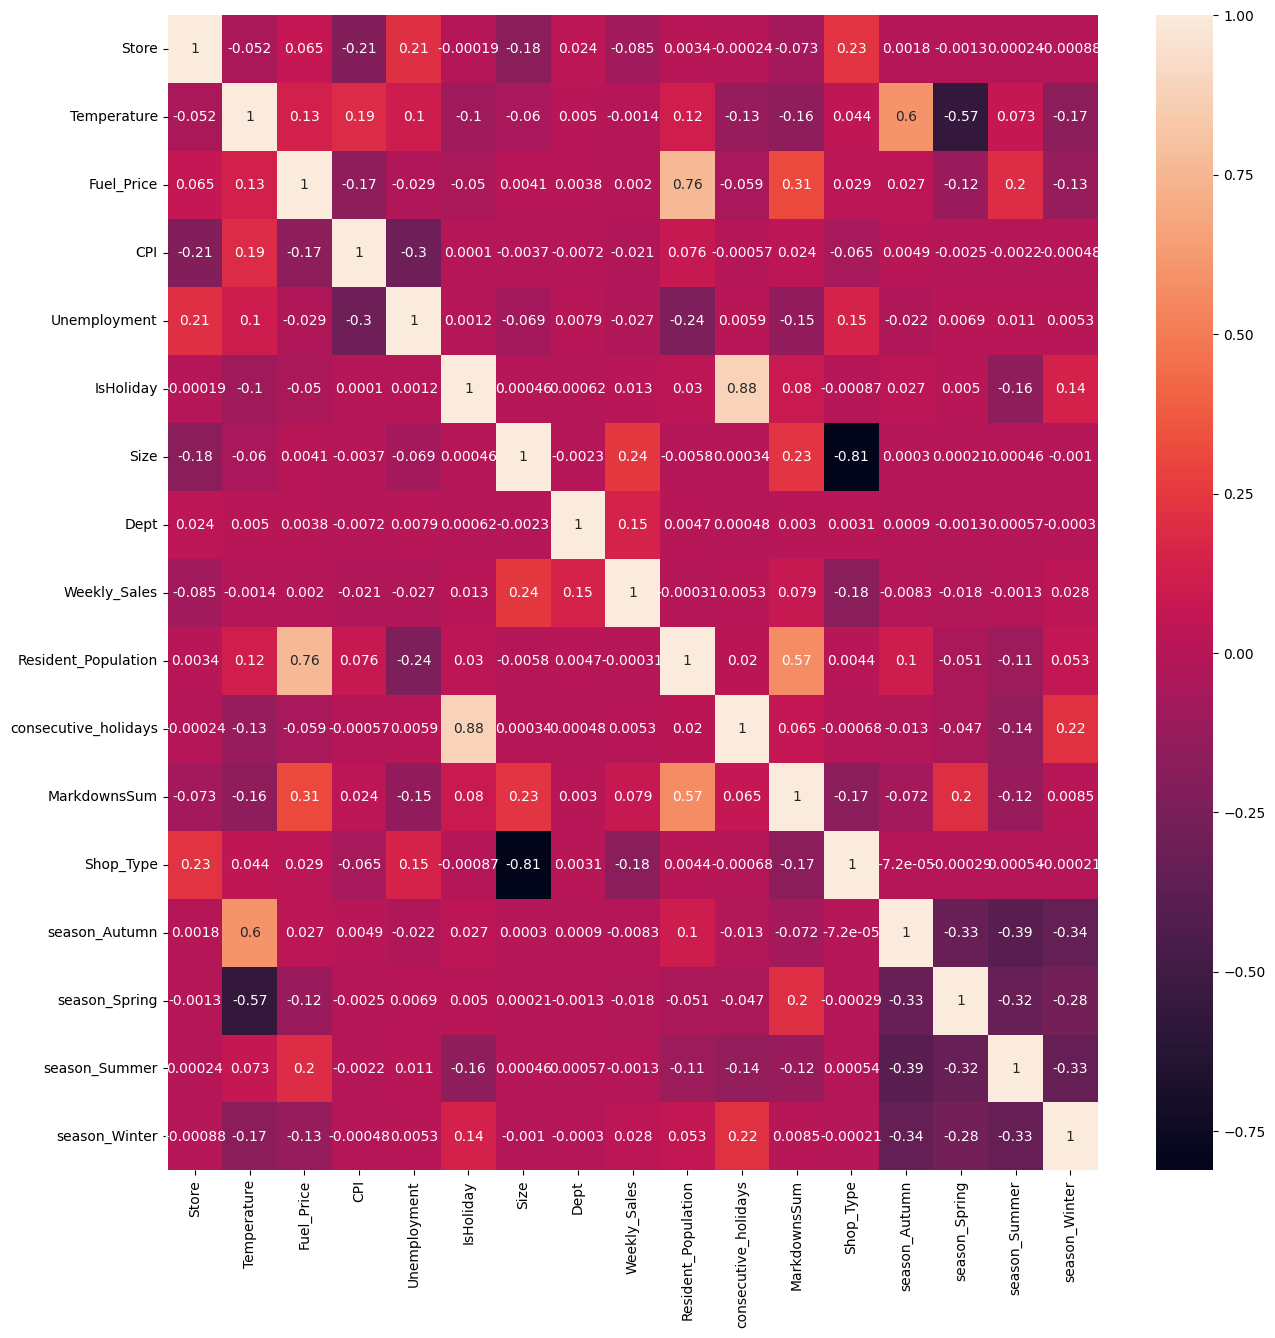

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

#特徴量と目的変数間の相関係数を計算
plt.figure(figsize=(15,15))
data=train_df.drop(columns='Date')
sns.heatmap(data.corr(),annot=True,fmt='.2g')

# feature selection

In [36]:
# drop high relationship features from heatmap

features = [i for i in train_data.columns if i not in ('consecutive_holidays','Date','Weekly_Sales','Shop_Type','Resident_Population')]
# List of categorical columns
#cat_cols = ['Date', 'Type', 'season']

# Convert categorical columns to category type
#for col in cat_cols:

  #  train_data[col] = train_data[col].astype('category')
  #  var_data[col] = var_data[col].astype('category')

In [37]:
X_train = train_data[features].copy()
y_train = train_data.Weekly_Sales.copy()


In [38]:
X_valid=var_data[features].copy()
y_valid = var_data.Weekly_Sales.copy()


In [39]:
X_test=test_data[features].copy()

In [ ]:
#X_train.to_csv("X_train_walmart.csv",index=False)
##y_train.to_csv("y_train_walmart.csv",index=False)
#X_valid.to_csv("X_valid_walmart.csv",index=False)
#y_valid.to_csv("y_valid_walmart.csv",index=False)
#X_test.to_csv("X_test_walmart.csv",index=False)

# model

In [68]:
# Eval metric for the competition
#def WMAE(dataset, real, predicted):
#    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
#    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [69]:
#models = {
#          '    LGBM': lgb.LGBMRegressor(random_state = 0),
         #' XGBoost': xgb.XGBRegressor(random_state = 0, objective = 'reg:squarederror'),
         # 'Catboost': cb.CatBoostRegressor(random_state = 0, verbose=False),          
         # '    HGBR': HistGradientBoostingRegressor(random_state = 0),
         # ' ExtraTr': ensemble.ExtraTreesRegressor(bootstrap = True, random_state = 0),
          #' RandomF': ensemble.RandomForestRegressor(random_state = 0),
 #        }

In [70]:
#def model_evaluation (name, model, models, X_train, y_train, X_valid, y_valid):
   
#    rmses = []
    
 #   for i in range(len(models)):
#    
        # Model fit
#        model.fit(X_train, y_train)
        
        # Model predict
#        y_preds = model.predict(X_valid)

        # RMSE
#        rmse = np.sqrt(np.mean((y_valid - y_preds)**2))
#        rmses.append(rmse)
        
#    return np.mean(rmses)

In [71]:
#for name, model in models.items():
#    print(name + ' Valid RMSE {:.4f}'.format(model_evaluation(name, model, models,  X_train, y_train, X_valid, y_valid)) )

    LGBM Valid RMSE 7235.0223


# LGBM tunning by Grid Search

In [44]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix,mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score

In [45]:
#時系列を考慮したクロスバリデーション
tscv = TimeSeriesSplit()
tscv.split(X_train, y_train)

param_grid1 = {
    'num_leaves':[5,10,20,30,40],
    'max_depth':[5,10,15,20],
    'n_estimators':[10,25,50,100,200],
    'reg_lambda':[0, 0.001, 0.01, 0.1, 1]

}


In [112]:
lgb_estimator = lgb.LGBMRegressor(random_state=0)
gsearch1 = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid1, cv=tscv, scoring = 'neg_root_mean_squared_error')
lgb_model1 = gsearch1.fit(X=X_train, y=y_train)


In [113]:
lgb_model1.best_params_

{'max_depth': 20, 'n_estimators': 100, 'num_leaves': 40, 'reg_lambda': 0.001}

In [114]:
np.sqrt( mean_squared_error(y_valid,lgb_model1.predict(X_valid) ) )


6400.775390094136

In [115]:
# detect in a small range

param_grid2 = {
    'num_leaves':[40,42,44,45],
    'max_depth':[18,19,20,21,22],
    'n_estimators':[80,100,120],
    'reg_lambda':[0.001, 0.01, 0.002]

}


In [116]:
gsearch2 = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid2, cv=tscv, scoring = 'neg_root_mean_squared_error')
lgb_model2 = gsearch2.fit(X=X_train, y=y_train)

In [117]:
lgb_model2.best_params_

{'max_depth': 21, 'n_estimators': 80, 'num_leaves': 40, 'reg_lambda': 0.001}

In [118]:
np.sqrt( mean_squared_error(y_valid,lgb_model2.predict(X_valid) ) )


6690.081490915128

# LGBM tunning by Hyperopt

In [46]:

params_hyperopt1 = {
    'num_leaves':hp.quniform('num_leaves',5,40,2),
    'max_depth':hp.quniform('max_depth',5,20,2),
    'n_estimators':hp.quniform('n_estimators',10,200,10),
    'reg_lambda':hp.loguniform('reg_lambda', np.log(0.001), np.log(1))
}

In [47]:
def objective(args):
    # ポイント！ int(args['ラベル'])を使って、整数型にする。
    args = {
        'num_leaves':int(args['num_leaves']),
        'max_depth':int(args['max_depth']),
        'n_estimators':int(args['n_estimators']),
        'reg_lambda':args['reg_lambda']

    }

    lgb_hyp = lgb.LGBMRegressor(**args, random_state=0)

    # cvとしてtscvを指定する
    score_array = cross_val_score(estimator=lgb_hyp, X=X_train, y=y_train, cv=tscv, scoring = 'neg_root_mean_squared_error')
    score_mean = np.mean(score_array)

    return -1*score_mean

In [48]:
# iterationする回数
max_evals = 500
# 試行の過程を記録するインスタンス
trials1 = Trials()

best1 = fmin(
    # 最小化する値を定義した関数
    objective,
    # 探索するパラメータのdictもしくはlist
    space=params_hyperopt1,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials1,
    # 試行の過程を出力
    verbose=1,
    # 結果再現のため乱数を固定
    #rstate=np.random.RandomState(0)
)

best1 = {
    'num_leaves':int(best1['num_leaves']),
    'max_depth':int(best1['max_depth']),
    'reg_lambda':best1['reg_lambda'],
    'n_estimators':int(best1['n_estimators'])

}
best1

100%|██████████| 500/500 [1:28:47<00:00, 10.66s/trial, best loss: 12767.098719905158]


{'num_leaves': 36,
 'max_depth': 20,
 'reg_lambda': 0.8728250152248831,
 'n_estimators': 160}

### Building LGBM Model

In [43]:
#build model with the best hyperparameters
LGBM=lgb.LGBMRegressor(n_estimators=160, 
                             max_depth=20,
                             num_leaves=36,
                             reg_lambda=0.8728250152248831,
                           
                            random_seed=0
                            )
LGBM.fit(X_train,y_train, eval_set=None)
print( np.sqrt(mean_squared_error(y_valid, LGBM.predict(X_valid))) )

6003.932076174386


In [46]:
# predict
y_preds=  LGBM.predict(X_valid)
predict_LGBM =  LGBM.predict(X_test)

# Permutation Importance

In [44]:
import eli5
from eli5.sklearn import PermutationImportance


In [45]:
perm = PermutationImportance(LGBM, random_state=1).fit(X_valid, y_valid)
features_weights = eli5.show_weights(perm, top=len(X_train.columns), feature_names = X_valid.columns.tolist())
features_weights

In [46]:
result = pd.read_html(features_weights.data)[0]
result

Weight        Feature
0   1.6063  ± 0.0148           Dept
1   0.4747  ± 0.0061           Size
2   0.1193  ± 0.0015          Store
3   0.0264  ± 0.0005            CPI
4   0.0062  ± 0.0002   Unemployment
5   0.0050  ± 0.0016  season_Winter
6   0.0040  ± 0.0002    Temperature
7   0.0026  ± 0.0019      IsHoliday
8   0.0021  ± 0.0001   MarkdownsSum
9   0.0020  ± 0.0001  season_Summer
10  0.0016  ± 0.0001  season_Autumn
11  0.0007  ± 0.0001  season_Spring
12  0.0001  ± 0.0001     Fuel_Price

# Graph

In [48]:
# train_index
x=train_data.set_index('Date')
x1=x[(x.Store==1)&(x.Dept==1)]
x1.head(2)

Store  Temperature  Fuel_Price         CPI  Unemployment  \
Date                                                                   
2010-02-26      1      41.8450     2.54875  211.236828         8.106   
2010-03-05      1      42.8925     2.56200  211.300275         8.106   

            IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
Date                                                                     
2010-02-26          0  151315     1      19403.54         3.083818e+08   
2010-03-05          0  151315     1      21827.90         3.084286e+08   

            consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
Date                                                                       
2010-02-26                     0           0.0          1            0.0   
2010-03-05                     0           0.0          1            0.0   

            season_Spring  season_Summer  season_Winter  
Date                                                     
2010-02-26            1.0            0.0            0.0  
2010-03-05            1.0            0.0            0.0

In [49]:
# var_data_index
y=var_data.set_index('Date')
y['DT'] = y_preds
y.head(2)

Store  Temperature  Fuel_Price         CPI  Unemployment  \
Date                                                                   
2012-03-02      1      52.8875       3.526  220.543971         7.348   
2012-03-09      1      55.5725       3.591  220.742474         7.348   

            IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
Date                                                                     
2012-03-02          0  151315     1      20113.03         3.129778e+08   
2012-03-09          0  151315     1      21140.07         3.130227e+08   

            consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
Date                                                                       
2012-03-02                     0     36455.310          1            0.0   
2012-03-09                     0     31544.895          1            0.0   

            season_Spring  season_Summer  season_Winter            DT  
Date                                                                   
2012-03-02            1.0            0.0            0.0  21433.733695  
2012-03-09            1.0            0.0            0.0  21341.575388

In [50]:
# var_data_index
y1=y[(y.Store==1)&(y.Dept==1)]
y1.head(2)

Store  Temperature  Fuel_Price         CPI  Unemployment  \
Date                                                                   
2012-03-02      1      52.8875       3.526  220.543971         7.348   
2012-03-09      1      55.5725       3.591  220.742474         7.348   

            IsHoliday    Size  Dept  Weekly_Sales  Resident_Population  \
Date                                                                     
2012-03-02          0  151315     1      20113.03         3.129778e+08   
2012-03-09          0  151315     1      21140.07         3.130227e+08   

            consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
Date                                                                       
2012-03-02                     0     36455.310          1            0.0   
2012-03-09                     0     31544.895          1            0.0   

            season_Spring  season_Summer  season_Winter            DT  
Date                                                                   
2012-03-02            1.0            0.0            0.0  21433.733695  
2012-03-09            1.0            0.0            0.0  21341.575388

In [51]:
# test_index
z=test_data.set_index('Date')
z['Predict'] = predict_LGBM
z.head(2)

Store  Temperature  Fuel_Price         CPI  Unemployment  \
Date                                                                   
2012-11-02      1        55.32       3.386  223.462779         6.573   
2012-11-09      1        61.24       3.314  223.481307         6.573   

            IsHoliday    Size  Dept  Resident_Population  \
Date                                                       
2012-11-02          0  151315     1          314695119.0   
2012-11-09          0  151315     1          314695119.0   

            consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
Date                                                                       
2012-11-02                     0      18342.28          1            0.0   
2012-11-09                     0      25633.44          1            0.0   

            season_Spring  season_Summer  season_Winter       Predict  
Date                                                                   
2012-11-02            0.0            0.0            1.0  28578.017277  
2012-11-09            0.0            0.0            1.0  26349.317838

In [52]:
# test_index
z1=z[(z.Store==1)&(z.Dept==1)]
z1.head(2)

Store  Temperature  Fuel_Price         CPI  Unemployment  \
Date                                                                   
2012-11-02      1        55.32       3.386  223.462779         6.573   
2012-11-09      1        61.24       3.314  223.481307         6.573   

            IsHoliday    Size  Dept  Resident_Population  \
Date                                                       
2012-11-02          0  151315     1          314695119.0   
2012-11-09          0  151315     1          314695119.0   

            consecutive_holidays  MarkdownsSum  Shop_Type  season_Autumn  \
Date                                                                       
2012-11-02                     0      18342.28          1            0.0   
2012-11-09                     0      25633.44          1            0.0   

            season_Spring  season_Summer  season_Winter       Predict  
Date                                                                   
2012-11-02            0.0            0.0            1.0  28578.017277  
2012-11-09            0.0            0.0            1.0  26349.317838

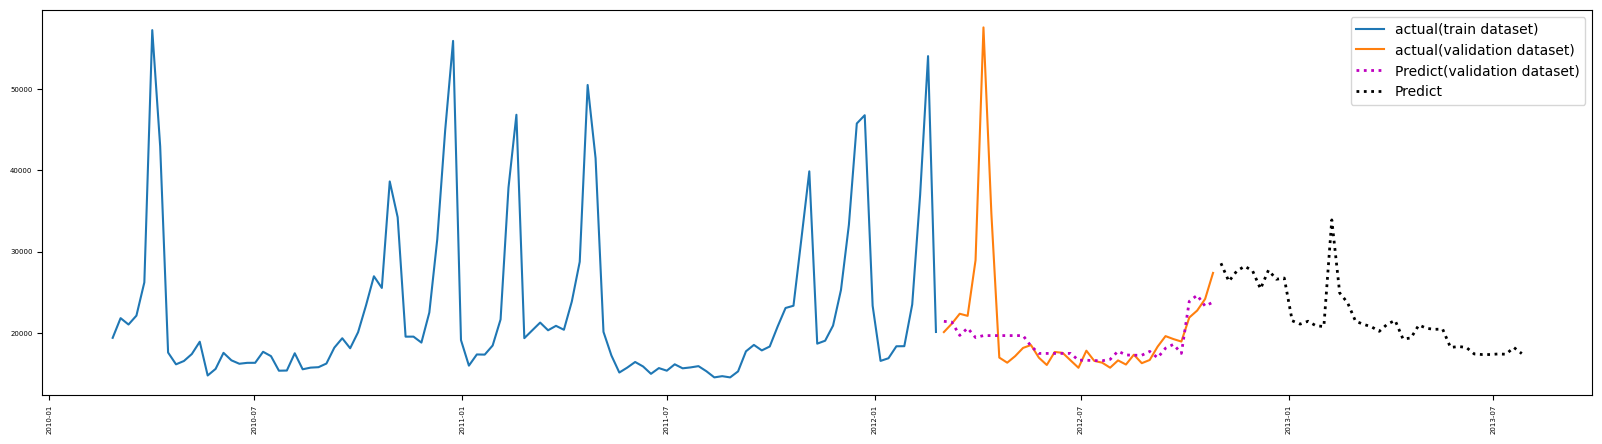

In [53]:
# グラフ化 store1 dep1
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x1.index, x1.Weekly_Sales, label="actual(train dataset)")
ax.plot(y1.index, y1.Weekly_Sales, label="actual(validation dataset)")

ax.plot(y1.index, y1.DT, label="Predict(validation dataset)", linestyle="dotted", lw=2, color="m") 
ax.plot(z1.index, z1.Predict,label="Predict", linestyle="dotted", lw=2,color="Black")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tick_params(labelsize=5)
plt.legend()

Convenience plot with ``partial_dependence_plots``


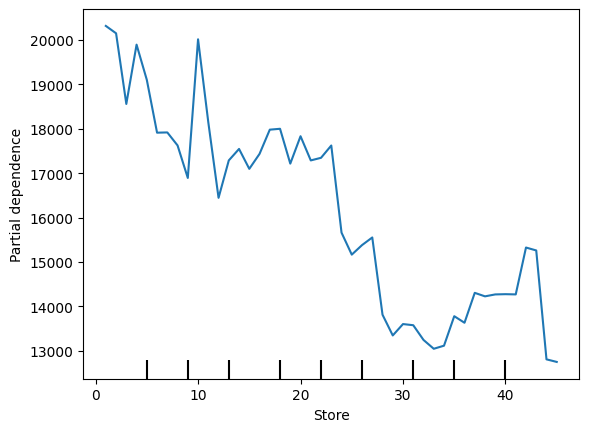

In [52]:
print('Convenience plot with ``partial_dependence_plots``')

features = [0]
PartialDependenceDisplay.from_estimator(LGBM, X_train, features,
                                   feature_names=X_train.columns.to_list(),
                                   )

In [54]:
from sklearn.inspection import partial_dependence

results = partial_dependence(LGBM, X_train, features)
results["average"]

array([[20319.53941589, 20153.22374583, 18560.51259219, 19897.47049846,
        19103.63981335, 17912.64350184, 17918.39859683, 17625.42829663,
        16891.73950464, 20017.87542995, 18147.19849453, 16443.91144833,
        17287.5639164 , 17546.08719314, 17097.35362975, 17434.65229563,
        17980.74422203, 18000.41742152, 17215.36040142, 17832.6353243 ,
        17287.5282086 , 17346.19872261, 17623.56909346, 15659.62963091,
        15163.18958828, 15378.10365743, 15550.32420982, 13809.02501511,
        13341.47240181, 13597.91541055, 13571.93917625, 13240.01848659,
        13040.9757195 , 13110.54503108, 13775.5306514 , 13627.24312733,
        14301.76203672, 14222.74901884, 14266.23447333, 14271.7347488 ,
        14266.5642536 , 15323.4495238 , 15257.45597158, 12802.58700001,
        12744.48565469]])

Convenience plot with ``partial_dependence_plots``


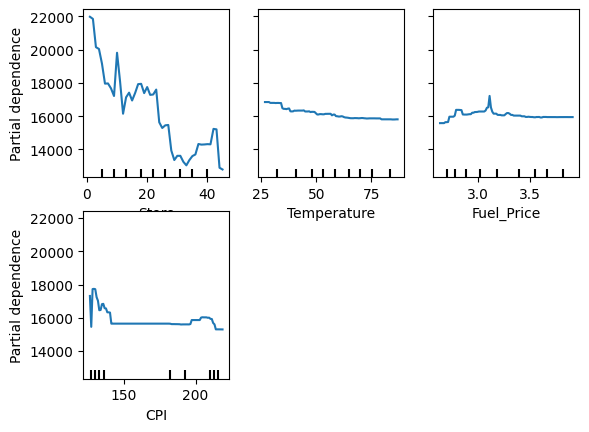

In [59]:
print('Convenience plot with ``partial_dependence_plots``')

features = [0, 1, 2, 3]
PartialDependenceDisplay.from_estimator(LGBM, X_train, features,
                                   feature_names=X_train.columns.to_list(),
                                   )

Convenience plot with ``partial_dependence_plots``


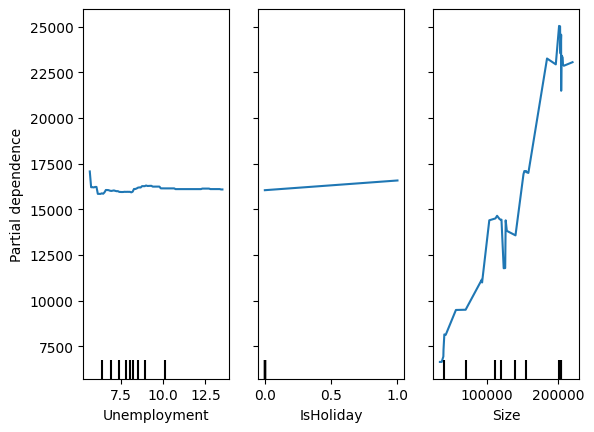

In [48]:
print('Convenience plot with ``partial_dependence_plots``')

features = [4, 5, 6]
PartialDependenceDisplay.from_estimator(LGBM, X_train, features,
                                   feature_names=X_train.columns.to_list(),
                                   )

Convenience plot with ``partial_dependence_plots``


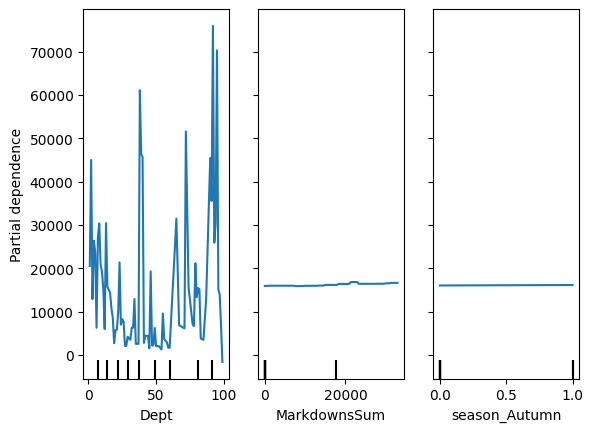

In [49]:
print('Convenience plot with ``partial_dependence_plots``')

features = [7, 8, 9]
PartialDependenceDisplay.from_estimator(LGBM, X_train, features,
                                   feature_names=X_train.columns.to_list(),
                                   )

Convenience plot with ``partial_dependence_plots``


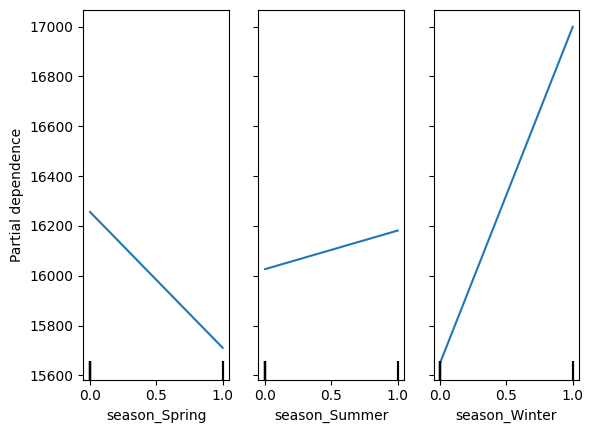

In [50]:
print('Convenience plot with ``partial_dependence_plots``')

features = [10, 11, 12]
PartialDependenceDisplay.from_estimator(LGBM, X_train, features,
                                   feature_names=X_train.columns.to_list(),
                                   )